## Import Libraries

In [76]:
# File handling
from pathlib import Path
from shutil import unpack_archive
import re
import openpyxl

# Data manipulation
import numpy as np
import scipy as sp
import pandas as pd
import math
from scipy import stats

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30

# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("ticks")
sns.despine()

<Figure size 640x480 with 0 Axes>

## Make Dataframe Containing the Spectrums

In [77]:
# Read in data from this path
excel_file_path = "kinetics_data.xlsx"

# Read the first sheet from the Excel file
df = pd.read_excel(excel_file_path, sheet_name=0, header=0, usecols="A:C")
df.columns.values[1] = 'Absorbance' + " " + df["Title"][0]
df = df.iloc[:, :2]

# Read the rest of the sheets from the Excel file
for i in range(1, 13):
    temp_df = pd.read_excel(excel_file_path, sheet_name=i, header=0, usecols="B:C")
    col_name = 'Absorbance' + " " + temp_df["Title"][0]
    df = pd.concat([df, temp_df.iloc[:, 0]], axis=1)
    df.columns.values[i+1] = col_name

lrow = df.iloc[:,-1]
lrow = lrow * 1.31
df.iloc[:, -1] = lrow

# Print the first five entries of each Excel sheet
df.head()

,Wavelength (nm),Absorbance 10th,Absorbance 11th,Absorbance 12th,Absorbance 1st,Absorbance 2nd,Absorbance 3rd,Absorbance 4th,Absorbance 5th,Absorbance 6th,Absorbance 7th,Absorbance 8th,Absorbance 9th,Absorbance cold
0,850,-0.011502,-0.011639,-0.011438,-0.013513,-0.014203,-0.012889,-0.014053,-0.009967,-0.012683,-0.013422,-0.013329,-0.008541,0.055389
1,849,-0.014107,-0.013884,-0.014669,-0.014093,-0.015348,-0.012426,-0.013100,-0.012080,-0.010947,-0.014389,-0.014686,-0.008197,0.055908
2,848,-0.010418,-0.010907,-0.012716,-0.014933,-0.013966,-0.014345,-0.012817,-0.011658,-0.014927,-0.015233,-0.013881,-0.010899,0.056401
3,847,-0.013982,-0.009657,-0.013238,-0.015378,-0.014724,-0.012105,-0.014260,-0.013977,-0.014794,-0.012844,-0.012171,-0.009072,0.051085
4,846,-0.011319,-0.012150,-0.012793,-0.015785,-0.017307,-0.013709,-0.013514,-0.014224,-0.013898,-0.013532,-0.014249,-0.007476,0.051605


## Plot Spectrum

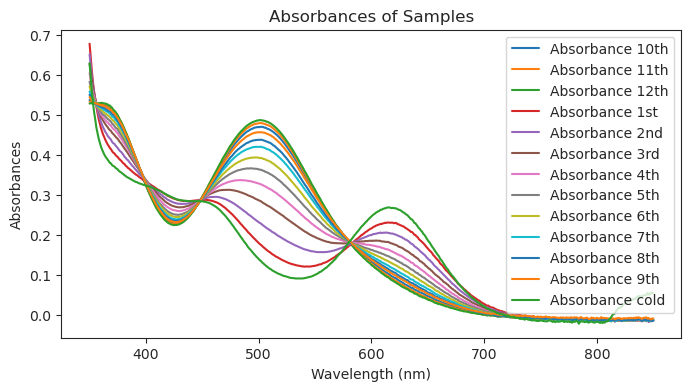

In [78]:
# Plot the Absorbances
plt.figure(figsize=(8, 4))  # Adjust the figure size if needed
plt.plot(df.iloc[:, 0], df.iloc[:, 1:], label=df.columns.values[1:])

# Customize the plot (add labels, legend, etc.)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbances")
plt.title("Absorbances of Samples")
plt.legend()

# Show the plot
plt.show()

## Pick Peaking

In [79]:
# This cell looks for the index at which 615 nm appears in the dataframe
value_to_find = 420

# Use boolean indexing to find rows where the second column equals the value_to_find
matching_rows = df[df["Wavelength (nm)"] == value_to_find]

# Check if there are any matching rows
if not matching_rows.empty:
    # Print the index of the first matching row
    index_of_first_match = matching_rows.index[0]
    print(f"The index of wavelength {value_to_find} nm is {index_of_first_match}.")
else:
    print(f"The value {value_to_find} is not found in the second column.")


The index of wavelength 420 nm is 430.


In [80]:
# Pick peak at 420 nm       
pick_peaks = df.iloc[430, :][1:].copy()   # Remove Wavelength column

# index 2 is absorbance at 12 mins
# index -1 is absorbance of cold

pick_peaks = list( (pick_peaks - pick_peaks[2])/(pick_peaks[-1]-pick_peaks[2]) )    
pick_peaks = pick_peaks[3:-1]    # Keep absorbances from 1 to 9 minutes

## Determine 0$^{th}$, 1$^{st}$, 2$^{nd}$ Reaction Order

In [81]:
# concentration of [M-Cl] at time t
conc_dicholro = [(x*0.01) for x in pick_peaks]  # [M-Cl]

# concentration of [M-H2O] at time t
conc_aqua = [( 0.01 - (x*0.01) ) for x in pick_peaks]  # [M-H2O]

In [82]:
# Time to be used for the Zero, First, and Second Order Fits
time = [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0]
time = [1, 2, 3, 4, 5, 6, 7, 8, 9]
time = [60*(x) for x in time]  # Convert time from minutes to seconds

#### Second Order: $1/[A]_t - 1/[A]_o = kt $

In [83]:
# Calculate the y-values for the second order integrated rate expression
second_order_y = []

for conc in conc_dicholro:
    second_order_y.append( 1/conc )  # 1/[M-Cl]

In [84]:
data_2nd_order = pd.DataFrame({'Time (sec)': time, "$1/[M-Cl]$": second_order_y})

# Calculate slope and x-intercept, and standard error of slope and x-intercept
fit_coeff, fit_cov = np.polyfit(time, second_order_y, 
                                1, cov=True)

# Finding the standard error of each coefficient 
fit_err = np.sqrt(np.diag(fit_cov))

print(f"The slope is: {round(fit_coeff[0], 6)}, and the std. err. of the slope is: {round(fit_err[0], 6)}, with x-intercept of: { round(fit_coeff[1], 4) }, with a standard error of", round(fit_err[1], 4))

The slope is: 1.293292, and the std. err. of the slope is: 0.175347, with x-intercept of: -71.9176, with a standard error of 59.2039


#### First Order: $ln([A]_t/[A]_o) = -kt$

In [85]:
# Calculate the y-values for the first order integrated rate expression
first_order_y = []

for conc in conc_dicholro:
    first_order_y.append( math.log(conc/0.01) )   # log([M-Cl]/[M-Cl]_0)

In [86]:
data_1st_order = pd.DataFrame({'Time (sec)': time, "ln$([M-Cl]/[M-Cl]_o$)": first_order_y})

# Calculate slope and x-intercept, and standard error of slope and x-intercept
fit_coeff, fit_cov = np.polyfit(time, first_order_y, 
                                1, cov=True)

# Rate Constant k
rate_first = -1 * fit_coeff[0]

# Finding the standard error of each coefficient 
fit_err = np.sqrt(np.diag(fit_cov))

# Error of calculated rate constant k
err_rate = fit_err[0]

print(f"The slope is: {round(rate_first, 6)}, and the std. err. of the slope is: {round(err_rate, 6)}, with x-intercept of: { round(fit_coeff[1], 4) }, with a standard error of", round(fit_err[1], 4))

The slope is: 0.004286, and the std. err. of the slope is: 0.000158, with x-intercept of: 0.357, with a standard error of 0.0533


#### Zero Order: $[A]_t = -kt + [A]_o$

In [87]:
# Calculate the y-values for the zero order integrated rate expression
zero_order_y = []

for conc in conc_dicholro:
    zero_order_y.append( (conc) )

In [88]:
data_0th_order = pd.DataFrame({'Time (sec)': time, "$[M-Cl]$" : zero_order_y})

fit_coeff, fit_cov = np.polyfit(time, zero_order_y, 
                                1, cov=True)

# Finding the standard error of each coefficient 
fit_err = np.sqrt(np.diag(fit_cov))

print(f"The slope is: {round(fit_coeff[0], 7)}, and the std. err. of the slope is: {round(fit_err[0], 6)}, with x-intercept of: { round(fit_coeff[1], 4) }, with a standard error of", round(fit_err[1], 4))

The slope is: -1.82e-05, and the std. err. of the slope is: 1e-06, with x-intercept of: 0.0103, with a standard error of 0.0004


#### Half-Life Calculation from First-Order Reaction

In [89]:
half_life = (0.693/ rate_first)
print("The half-life is", round(half_life, 2), "seconds.")

The half-life is 161.7 seconds.


## Plot All Linear Regression Models

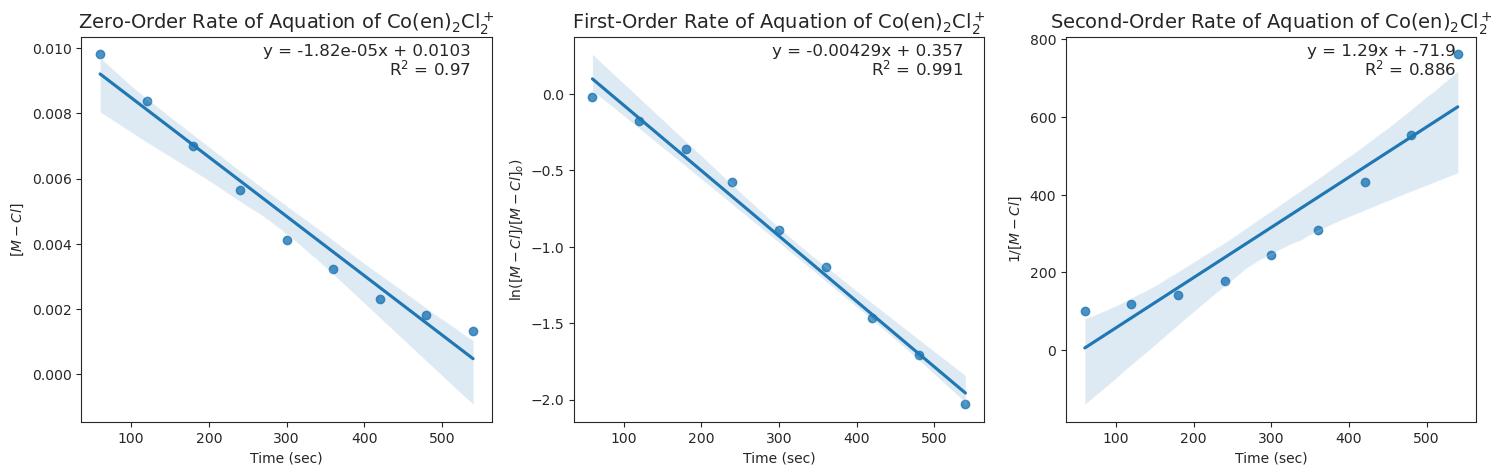

In [90]:
# Define a function to create the plot with title and regression statistics
def plot_with_title_and_stats(data, x_col, y_col, title, ax):
    sns.regplot(data=data, x=x_col, y=y_col, ax=ax)
    
    # Calculate regression statistics
    slope, intercept, r_value, p_value, std_err = stats.linregress(data[x_col], data[y_col])
    
    # Round values to three significant figures
    slope_str = "{:.3g}".format(slope)
    intercept_str = "{:.3g}".format(intercept)
    r_squared_str = "{:.3g}".format(r_value**2)
    
    # Create the equation of the fit
    equation = f'y = {slope_str}x + {intercept_str}'
    r_squared = f'R$^2$ = {r_squared_str}'
    
    # Add the provided title, equation, and R² value as text
    ax.set_title(title, fontsize=14)
    ax.text(0.95, 0.95, equation, transform=ax.transAxes, fontsize=12, ha='right')
    ax.text(0.95, 0.9, r_squared, transform=ax.transAxes, fontsize=12, ha='right')

# Set up figure
fig, axs = plt.subplots(ncols=3, figsize=(18, 5))

# The titles of each plot
titles = ["Zero-Order Rate of Aquation of Co(en)$_{2}$Cl$_2^+$", "First-Order Rate of Aquation of Co(en)$_{2}$Cl$_2^+$", 
          "Second-Order Rate of Aquation of Co(en)$_{2}$Cl$_2^+$"]

# Plot and add title and statistics for each dataset
plot_with_title_and_stats(data_0th_order, data_0th_order.columns[0], data_0th_order.columns[1], titles[0], axs[0])
plot_with_title_and_stats(data_1st_order, data_1st_order.columns[0], data_1st_order.columns[1], titles[1], axs[1])
plot_with_title_and_stats(data_2nd_order, data_2nd_order.columns[0], data_2nd_order.columns[1], titles[2], axs[2])

plt.show()

## Activation Energy

In [91]:
# Create a dictionary
data_activ_energy = {
    '$1/T$ ($^o$C)': [1/55, 1/60, 1/65, 1/70, 1/75],
    "ln(t$_{1/2}$) (sec)": [60*2.14, 60*1.50, 60*0.78, 60*0.69, 60*0.15],
}

# The dictionary above will be turned into a DataFrame
activ_energy_df = pd.DataFrame(data_activ_energy)
activ_energy_df.iloc[:, 1] = np.log( activ_energy_df.iloc[:, 1] )
activ_energy_df

,$1/T$ ($^o$C),ln(t$_{1/2}$) (sec)
0,0.018182,4.855150
1,0.016667,4.499810
2,0.015385,3.845883
3,0.014286,3.723281
4,0.013333,2.197225


/home/jupyter-brandonc/.local/lib/python3.9/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


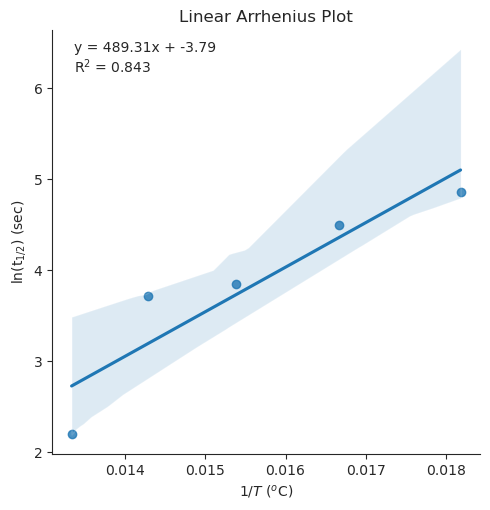

In [92]:
# Perform linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(activ_energy_df[activ_energy_df.columns[0]], 
                                                               activ_energy_df[activ_energy_df.columns[1]])

# Calculate the regression equation
regression_equation = f"y = {slope:.2f}x + {intercept:.2f}"

# Calculate R-squared (coefficient of determination)
r_squared = r_value**2

# Create the plot
lm = sns.lmplot(data=activ_energy_df, x=activ_energy_df.columns[0], y=activ_energy_df.columns[1])
plt.title("Linear Arrhenius Plot")

# Add the regression equation and R-squared to the plot
plt.text(0.05, 0.95, regression_equation, transform=lm.ax.transAxes, fontsize=10)
plt.text(0.05, 0.9, f"R$^2$ = {r_squared:.3f}", transform=lm.ax.transAxes, fontsize=10)

# Show the plot
plt.show()


In [93]:
# Perform Linear Regression again
fit_coeff, fit_cov = np.polyfit(activ_energy_df[activ_energy_df.columns[0]], 
                                activ_energy_df[activ_energy_df.columns[1]], 
                                1, cov=True)

# Finding the standard error of each coefficient 
fit_err = np.sqrt(np.diag(fit_cov))

# Slope: E_a/R and x-intercept: ln(A)
slope_activ = fit_coeff[0]
xintercept_activ = fit_coeff[1]

# Error of Slope
err_slope_activ = fit_err[0]
err_xintercept_activ = fit_err[1]

# Print coefficients of the model and their error
print(f"The slope is: {round(fit_coeff[0], 4)}, and the std. err. of the slope is: {round(fit_err[0], 4)}, with x-intercept of: { round(fit_coeff[1], 4) } with a standard error of", round(fit_err[1], 4))

The slope is: 489.3147, and the std. err. of the slope is: 121.8124, with x-intercept of: -3.7946 with a standard error of 1.9081


#### ln(k) = (-E$_a$/R)*(1/T) + ln(A)
#### ln($t_{1/2}$) = (-E$_a$/R)*(1/T) + ln(A)

#Slope is -E$_a$/R.

#R is the gas constant, 8.314 J/(mol*K)

#A is the pre-exponential factor.


In [94]:
activation_energy = slope_activ * (8.314)  # Units: J/mol
activation_energy

4068.1622101682083

In [98]:
fit_coeff[1]

-3.7945699444839405

In [95]:
pre_exp_fact = math.exp(round(fit_coeff[1], 4))
pre_exp_fact

0.02249190077793453